# Import relevant files

In [1]:
from src.mtl import MultiTaskModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/Users/manan/Desktop/Leetcode/Fetch Assesment/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Instantiate the Model

In [2]:
model = MultiTaskModel(backbone_pth='models/backbone')

Model loaded from models/backbone


/Users/manan/Desktop/Leetcode/Fetch Assesment/src/embedding_model.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.projection.load_state_dict(torch.load(f"{path}/pr

#### Task A is Sentence classification into 4 categories
#### Task B is Sentiment Analysis with 3 categories (Positve, Negative or Neutral)

#### Assuming that input data (sentences) have two labels: one for classification and one for sentiment

## Sample Synthetic Data


In [ ]:
# Synthetic data load from a CSV file for demonstration. 
# NOTE: Data was generated using generative AI.

data = pd.read_csv('data/synthetic_data.csv')

class NewsSentimentDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return row["sentence"], row["labelA"], row["labelB"]


train_dataloader = DataLoader(NewsSentimentDataset(data[:100]), batch_size=16, shuffle=True)
val_dataloader   = DataLoader(NewsSentimentDataset(data[100:]), batch_size=16, shuffle=False)

for sentences, labelsA, labelsB in train_dataloader:
    print(sentences)
    print(labelsA, labelsB)
    break

('World Cup champions updates its policy framework.', 'Star quarterback encounters unexpected setbacks.', 'A leading AI startup delays project rollout.', 'A leading AI startup announces its quarterly earnings.', 'Open-source community faces scrutiny over recent decisions.', 'World Cup champions releases its annual report.', 'Local baseball club sees decline in public support.', 'Cybersecurity firm celebrates major victory.', 'Software company achieves major breakthrough.', 'Famous actor announces record-breaking success.', 'Film festival receives widespread acclaim.', 'Olympic sprinter updates its policy framework.', 'The national football team sees decline in public support.', 'Star quarterback receives widespread acclaim.', 'Open-source community sees decline in public support.', 'The Supreme Court encounters unexpected setbacks.')
tensor([1, 1, 2, 2, 2, 1, 1, 2, 2, 3, 3, 1, 1, 1, 2, 0]) tensor([1, 2, 2, 1, 2, 1, 2, 0, 0, 0, 0, 1, 2, 0, 2, 2])


# Training Loop (Task 4)

In [4]:
# BASELINE METRICS: Accuracy, Recall, Precision


accA, accB, recallA, recallB, precisionA, precisionB = model.metrics(val_dataloader)
print(f"Validation Accuracy: A: {accA:.4f}, B: {accB:.4f}")
print(f"Validation Recall: A: {recallA:.4f}, B: {recallB:.4f}")
print(f"Validation Precision: A: {precisionA:.4f}, B: {precisionB:.4f}")

Validation Accuracy: A: 0.2500, B: 0.2500
Validation Recall: A: 0.0000, B: 0.0000
Validation Precision: A: 0.0000, B: 0.0000


## Training loop - Version 1 (Three phase training)

All backbone layers frozen
Task A head unfrozen
Task B head unfrozen
Model saved to best_model
Model saved to best_model
Epoch 1/10 - train_loss: 2.4745  val_loss: 2.5049  A_acc: 25.00%  B_acc: 25.00%
Model saved to best_model
Model saved to best_model
Epoch 2/10 - train_loss: 2.4359  val_loss: 2.4728  A_acc: 25.00%  B_acc: 25.00%
Model saved to best_model
Model saved to best_model
Epoch 3/10 - train_loss: 2.3556  val_loss: 2.4202  A_acc: 25.00%  B_acc: 40.00%
Model saved to best_model
Model saved to best_model
Epoch 4/10 - train_loss: 2.2795  val_loss: 2.3913  A_acc: 35.00%  B_acc: 55.00%
Model saved to best_model
Model saved to best_model
Epoch 5/10 - train_loss: 2.1870  val_loss: 2.3502  A_acc: 55.00%  B_acc: 55.00%
Model saved to best_model
Model saved to best_model
Epoch 6/10 - train_loss: 2.0976  val_loss: 2.3152  A_acc: 55.00%  B_acc: 50.00%
Model saved to best_model
Model saved to best_model
Epoch 7/10 - train_loss: 2.0299  val_loss: 2.2819  A_acc: 55.00%  B_acc: 50.00%
Model s

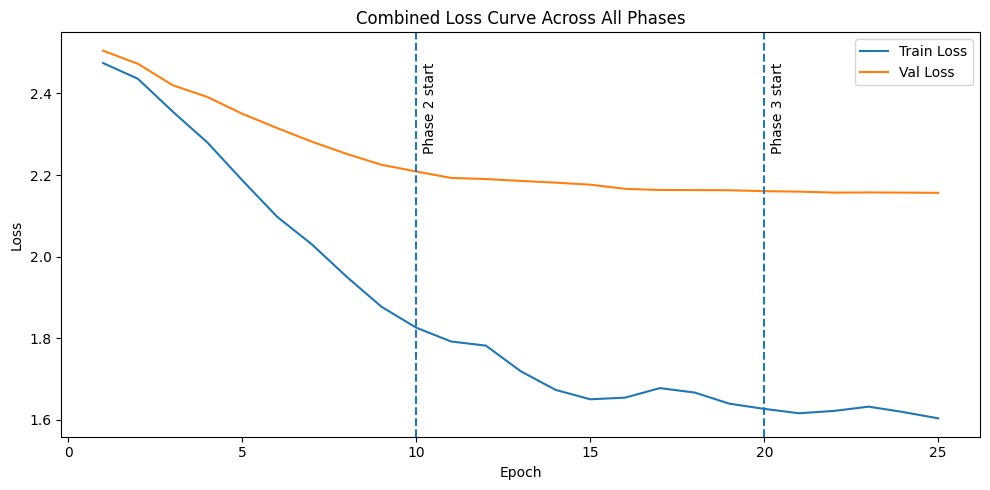

In [ ]:
# Assuming that train_dataloarder and val_dataloader are defined

# Losses
lossA = nn.CrossEntropyLoss()
lossB = nn.CrossEntropyLoss()

# Phase 1: Epochs 1–10 (backbone frozen, train projection + both heads, lr: 1e-3)
model.freeze_backbone()            # lock all Transformer layers
model.unfreeze_projection()        #  unfreeze projection layer
model.unfreeze_taskA_head()        #  unfreeze Task A head
model.unfreeze_taskB_head()        #  unfreeze Task B head

opt1 = optim.AdamW([
    {'params': model.backbone.projection.parameters(), 'lr': 1e-3},
    {'params': model.taskA_head.parameters(),          'lr': 1e-3},
    {'params': model.taskB_head.parameters(),          'lr': 1e-3},
])
sched1 = StepLR(opt1, step_size=3, gamma=0.5)

history1 = model.fit(
    train_dataloader,
    val_dataloader,
    opt1,
    lossA,
    lossB,
    epochs=10,
    scheduler=sched1
)

# Phase 2: Epochs 11–20 (unfreeze top 2 Transformer layers, lr backbone=1e-5, heads+proj=1e-4)
model.freeze_backbone()            # re‐freeze all backbone layers
model.unfreeze_backbone(num=2)     # unfreeze just the last 2 backbone layers
model.unfreeze_projection()        # projection unfrozen
model.unfreeze_taskA_head()        # headA unfrozen
model.unfreeze_taskB_head()        # headB unfrozen

# collect trainable backbone params
backbone_params = [p for p in model.backbone.model.parameters() if p.requires_grad]
head_and_proj = (
    list(model.backbone.projection.parameters()) +
    list(model.taskA_head.parameters()) +
    list(model.taskB_head.parameters())
)

opt2 = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': head_and_proj,    'lr': 1e-4},
])
sched2 = StepLR(opt2, step_size=3, gamma=0.5)

history2 = model.fit(
    train_dataloader,
    val_dataloader,
    opt2,
    lossA,
    lossB,
    epochs=10,
    scheduler=sched2
)

# hase 3: Epochs 21-25 (gradual unfreeze:fully unfreeze and fine‐tune with lower LRs)
model.unfreeze_backbone()          # all layers now trainable
model.unfreeze_projection()
model.unfreeze_taskA_head()
model.unfreeze_taskB_head()

all_backbone = list(model.backbone.model.parameters())
all_proj_and_heads = (
    list(model.backbone.projection.parameters()) +
    list(model.taskA_head.parameters()) +
    list(model.taskB_head.parameters())
)

opt3 = optim.AdamW([
    {'params': all_backbone,       'lr': 1e-6},
    {'params': all_proj_and_heads, 'lr': 1e-5},
])
sched3 = StepLR(opt3, step_size=3, gamma=0.5)

history3 = model.fit(
    train_dataloader,
    val_dataloader,
    opt3,
    lossA,
    lossB,
    epochs=5,
    scheduler=sched3
)
# stitch together the losses from each phase
train_losses = history1['train_loss'] + history2['train_loss'] + history3['train_loss']
val_losses   = history1['val_loss']   + history2['val_loss']   + history3['val_loss']

total_epochs = len(train_losses)
epochs = list(range(1, total_epochs + 1))

# compute phase boundaries
p1_end = len(history1['train_loss'])
p2_end = p1_end + len(history2['train_loss'])

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')

#draw and label the phase splits
for idx, bound in enumerate([p1_end, p2_end], start=1):
    plt.axvline(bound, linestyle='--')
    plt.text(bound + 0.2, max(train_losses), f'Phase {idx+1} start', rotation=90, va='top')

plt.title('Combined Loss Curve Across All Phases')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# FINAL METRICS
f_accA, f_accB, f_recallA, f_recallB, f_precisionA, f_precisionB = model.metrics(val_dataloader)
print(f"Final Validation Accuracy: A: {f_accA:.4f}, B: {f_accB:.4f}")
print(f"Final Validation Recall: A: {f_recallA:.4f}, B: {f_recallB:.4f}")
print(f"Final Validation Precision: A: {f_precisionA:.4f}, B: {f_precisionB:.4f}")

Final Validation Accuracy: A: 0.7000, B: 0.5500
Final Validation Recall: A: 1.0000, B: 0.2500
Final Validation Precision: A: 1.0000, B: 1.0000


## Alternate version - Training All Parameters together

In [ ]:
# UNCOMMENT THIS BLOCK TO TRAIN THE MODEL USING ALTERNATE STRATEGY

# # 1) Make sure everything is unfrozen so gradients are computed
# model.unfreeze_backbone()
# model.unfreeze_projection()
# model.unfreeze_taskA_head()
# model.unfreeze_taskB_head()

# # 2) Losses
# class_lossA = nn.CrossEntropyLoss()
# sentiment_lossB = nn.CrossEntropyLoss()

# # 3) Optimizer with parameter groups
# model_optimizer = optim.AdamW([
#     {'params': model.backbone.model.parameters(),     'lr': 1e-5}, # slower backbone LR to ensure backbone is not overfitted
#     {'params': model.backbone.projection.parameters(), 'lr': 1e-4},
#     {'params': model.taskA_head.parameters(),          'lr': 1e-4},
#     {'params': model.taskB_head.parameters(),          'lr': 1e-4},
# ])

# # 4) Scheduler
# scheduler = StepLR(model_optimizer, step_size=2, gamma=0.5)

# # 5) Train/val loop via your fit helper
# history = model.fit(train_loader=train_dataloader,
#                     val_loader=val_dataloader,
#                     optimizer=model_optimizer,
#                     lossA=class_lossA,
#                     lossB=sentiment_lossB,
#                     epochs=20,
#                     scheduler=scheduler
#                     )

# # 6) Plotting
# plt.plot(history['train_loss'], label='Train Loss')
# plt.plot(history['val_loss'], label='Validation Loss')
# plt.title('Losses')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()